In [1]:
#### 
### Load / visualize the unbinned data with arrow plot 

In [1]:
from resim_ppf import ppf_pa, file_key
import analysis_config

from riglib.bmi import train

%load_ext autoreload
%autoreload 2
%matplotlib notebook

in task
in task
in task


In [30]:
def extract_trials(day = 0, task = 0, task_ix = 0, unbinned_flag = True):
    filename = file_key.task_filelist[day][task][task_ix]
    binsize_ms = 100.
    bin_spk, targ_i_all, targ_ix, trial_ix_all, decoder_all, ck, unbinned, exclude = ppf_pa.get_jeev_trials_from_task_data(filename, 
                    binsize=binsize_ms/1000., include_pos = True, pre_go = .2)
    ### Get decoder A ###
    dec = train.load_PPFDecoder_from_mat_file(analysis_config.config['jeev_pref']+filename)
    A = dec.filt.A; 
    C = dec.filt.C; 
    print('exclude')
    print(exclude)
    
    ### Organize unbinned into 
    ### Can easily get the Kalman Gain from the saved ones; This 
    kgs = pickle.load(open(analysis_config.config['jeev_pref']+'jeev_KG_approx_fit.pkl', 'rb'))
    kg = kgs[day]/100.
    print(ck[0].shape)
    
    if unbinned_flag: 
        ck = unbinned['cursor_kin'] ### in meters 
        print('unbinned ck:')
        print(ck[0].shape)
        ub_spks = unbinned['spike_counts']
        ub_est_np = [np.squeeze(np.array(np.dot(kg, ub_spks[i]))) for i in range(len(ub_spks))]
        return A, C, kg, ck, ub_est_np
    
    else:
        est_np = [np.squeeze(np.array(np.dot(kg, bin_spk[i].T).T)) for i in range(len(bin_spk))]
        print('binned ck: ')
        print(ck[0].shape)
        return A, C, kg, ck, est_np

In [56]:
def plot_unbinned_trl(ck, A, kg, C, ub_est_np):
    
    ######## PLOT OF UNBINNED ######
    f, ax = plt.subplots()
    plt.plot(ck[:, 0], ck[:, 2], 'k.')

    pos_tm1 = ck[:-1, [0, 2]]

    ### General Vt-1: P_t = P_{t-1} + .005*V_{t-1}
    vel_tm1 = 0.005*ck[:-1, [3, 5]]
    ax.quiver(pos_tm1[:, 0], pos_tm1[:, 1], vel_tm1[:, 0], vel_tm1[:, 1], 
             width=.004, color='k', angles='xy', scale=1, scale_units='xy', 
              label = 'V_{t-1}')

    ### .005*V_{t-1} = 0.005*(alpha*V_{t-2} - Ke^{CAx} + Ky_{t-1})

    alpha = A[3, 3]

    ### 0.005*alpha*Vt-2 
    vel_tm2 = 0.005*alpha*ck[:-2, [3, 5]]
    ax.quiver(pos_tm1[1:, 0], pos_tm1[1:, 1], vel_tm2[:, 0], vel_tm2[:, 1], 
             width=.004, color='b', angles='xy', scale=1, scale_units='xy', 
              label = 'a V_{t-2}')

    ### 0.005*Ky_{t-1}: Actual Neural push 
#     np_tm1 = 0.005*(ub_np[[3, 5], :-1]/100.)
#     ax.quiver(pos_tm1[:, 0], pos_tm1[:, 1], np_tm1[0, :], np_tm1[1, :], 
#              width=.004, color='r', angles='xy', scale=1, scale_units='xy', 
#               label = 'actual KG')

    ### 0.005*Ky_{t-1}: Neural push estimated from fixed KG 
    np_tm1 = 0.005*(ub_est_np[[0, 1], :-1])
    ax.quiver(pos_tm1[:, 0], pos_tm1[:, 1], np_tm1[0, :], np_tm1[1, :], 
             width=.004, color='magenta', angles='xy', scale=1, scale_units='xy', 
              label = 'est KG')

    ## -0.005*Ke^{CAx_{t-1}}: Effect of push estimated; 
    CAx = np.dot(C, np.dot(A, ck[:-2, :].T))
    Kexp_CAx = np.squeeze(np.array(-0.005*np.dot(kg, np.exp(CAx))))
    ax.quiver(pos_tm1[1:, 0], pos_tm1[1:, 1], Kexp_CAx[0, :], Kexp_CAx[1, :], 
             width=.004, color='r', angles='xy', scale=1, scale_units='xy', 
              label = '$Ke^{CAx_{t-1}}$')

    ### Comb:  0.005*(alpha*V_{t-2} - Ke^{CAx} + Ky_{t-1})
    sum_tm = vel_tm2 + np_tm1[:, 1:].T + Kexp_CAx.T
    ax.quiver(pos_tm1[1:, 0], pos_tm1[1:, 1], sum_tm[:, 0], sum_tm[:, 1], 
             width=.004, color='g', angles='xy', scale=1, scale_units='xy', 
              label = 'sum')

    f.legend()

In [ ]:
def plot_binned_trl(ck, A, kg, C, est_np, ub_ck):
    
    ######## PLOT OF UNBINNED ######
    f, ax = plt.subplots()
    
    #### Get indices for binning ####
    bin_ix = np.arange(0., ub_ck.shape[0], 20).astype(int)
    
    #### Plot these positions ####
    plt.plot(ub_ck[bin_ix, 0], ub_ck[bin_ix, 2], 'k.')
    
    ### now these positions are used as anchor points; 
    pos_tm1 = ub_ck[np.ix_(bin_ix[:-1], [0, 2])]

    ### General Vt-1: P_t = P_{t-1} + .005*V_{t-1}
    ### Already summed up velocities, so still need to multiply by 0.005
    vel_tm1 = 0.005*ck[:-1, [3, 5]]
    ax.quiver(pos_tm1[:, 0], pos_tm1[:, 1], vel_tm1[:, 0], vel_tm1[:, 1], 
             width=.004, color='k', angles='xy', scale=1, scale_units='xy', 
              label = 'V_{t-1}')

    ### Now, need to split up the velocities
    ### .005*V_{t-1} = 0.005*(alpha*V_{t-2} - Ke^{CAx} + Ky_{t-1})

    alpha = A[3, 3]

###############################################################
####### 0.005*alpha*Vt-2 ######################################
###############################################################
    vel_tm2 = []
    for b in bin_ix[1:-1]:
        vel_tm2.append(0.005*alpha*np.sum(ub_ck[b-1:b-1+20, [3, 5]], axis=0))
    vel_tm2 = np.vstack((vel_tm2))
    ax.quiver(pos_tm1[1:, 0], pos_tm1[1:, 1], vel_tm2[:, 0], vel_tm2[:, 1], 
             width=.004, color='b', angles='xy', scale=1, scale_units='xy', 
              label = 'a V_{t-2}')

#     ### 0.005*Ky_{t-1}: Actual Neural push 
#     np_tm1 = 0.005*(ub_np[[3, 5], :-1]/100.)
#     ax.quiver(pos_tm1[:, 0], pos_tm1[:, 1], np_tm1[0, :], np_tm1[1, :], 
#              width=.004, color='r', angles='xy', scale=1, scale_units='xy', 
#               label = 'actual KG')

##################################################################
####### 0.005*Ky_{t-1}: Neural push estimated from fixed KG ######
##################################################################
    np_tm1 = 0.005*(est_np[:-1, [0, 1]])
    ax.quiver(pos_tm1[:, 0], pos_tm1[:, 1], np_tm1[:, 0], np_tm1[:, 1], 
             width=.004, color='magenta', angles='xy', scale=1, scale_units='xy', 
              label = 'est KG')

###############################################################
####### -0.005*Ke^{CAx_{t-1}}: Effect of push estimated; ######
###############################################################
    Kexp_CAx = []
    for b in bin_ix[1:-1]:
        bv = []
        for bi in range(b-1, b-1+20):
            bi_tmp = np.squeeze(np.array(ub_ck[bi, :]))[:, np.newaxis]
            bv.append(np.squeeze(np.array(-0.005*np.dot(kg, np.exp(np.dot(C, np.dot(A, bi_tmp)))))))
        bv = np.vstack((bv))
        Kexp_CAx.append(np.sum(bv, axis=0))
    Kexp_CAx = np.vstack((Kexp_CAx))    
    ax.quiver(pos_tm1[1:, 0], pos_tm1[1:, 1], Kexp_CAx[:, 0], Kexp_CAx[:, 1], 
             width=.004, color='r', angles='xy', scale=1, scale_units='xy', 
              label = '$Ke^{CAx_{t-1}}$')
###############################################################
####### Comb:  0.005*(alpha*V_{t-2} - Ke^{CAx} + Ky_{t-1}) ######
###############################################################
    sum_tm = vel_tm2 + np_tm1[1:, :] + Kexp_CAx
    ax.quiver(pos_tm1[1:, 0], pos_tm1[1:, 1], sum_tm[:, 0], sum_tm[:, 1], 
             width=.004, color='g', angles='xy', scale=1, scale_units='xy', 
              label = 'sum')

    f.legend()

In [31]:
#### Get day 0 @@@@
A, C, kg, ub_ck, ub_est_np = extract_trials(day=0, task=0, task_ix=0, unbinned_flag = True)

199 (17, 7)
exclude
[]
(17, 7)
unbinned ck:
(333, 7)


<IPython.core.display.Javascript object>


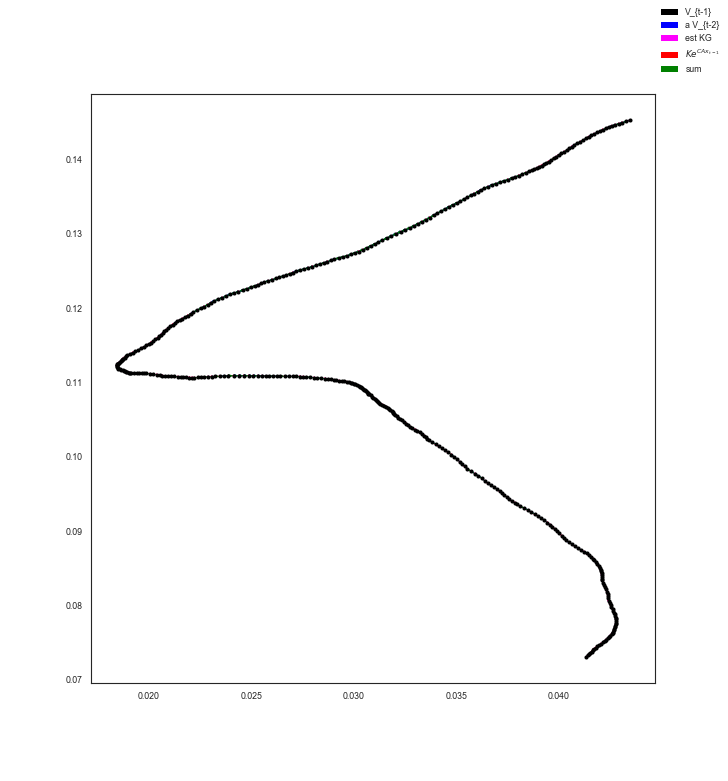

In [54]:
#### plot ###
trial = 5
plot_unbinned_trl(ub_ck[trial], A, kg, C, ub_est_np[trial])

In [34]:
A, C, kg, ck, est_np = extract_trials(day=0, task=0, task_ix=0, unbinned_flag = False)

199 (17, 7)
exclude
[]
(17, 7)
binned ck: 
(17, 7)


<IPython.core.display.Javascript object>


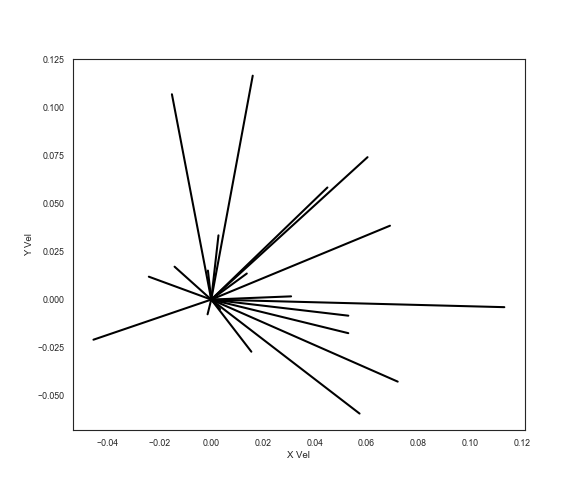

Text(0,0.5,'Y Vel')

In [51]:
f, ax = plt.subplots()
for i in range(C.shape[0]):
    plt.plot([0, C[i, 3]], [0, C[i, 5]], 'k-')
ax.set_xlabel('X Vel')
ax.set_ylabel('Y Vel')

<IPython.core.display.Javascript object>


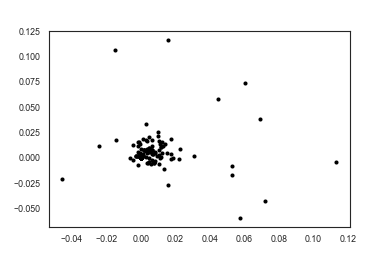

In [35]:
ub_est_np[0][1, :]
#ub_est_np[0] = np.squeeze(np.array(ub_est_np[0]))
f, ax = plt.subplots()
plt.plot(ub_est_np[0][0, :], ub_est_np[0][1, :], 'k.')

<IPython.core.display.Javascript object>


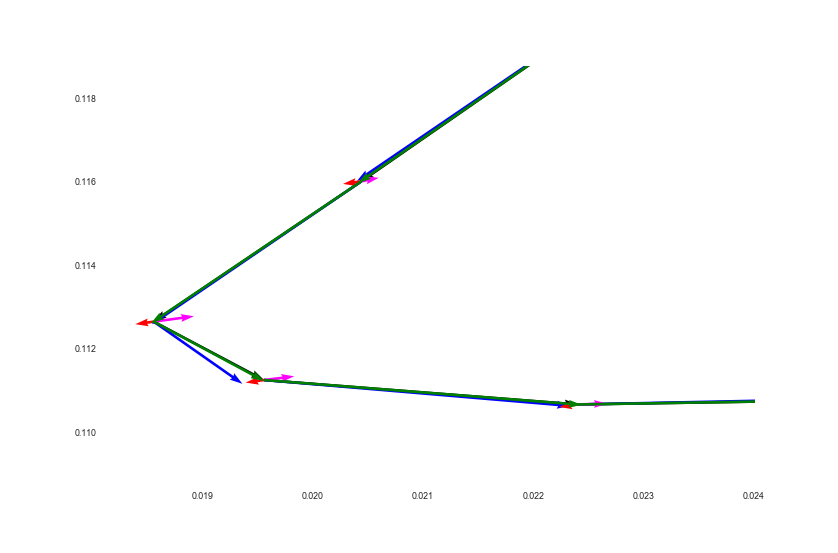

In [55]:
plot_binned_trl(ck[5], A, kg, C, est_np[5], ub_ck[5])

In [80]:
############ Get a distribution of the red arrow --- make sure it doesnt' do the task..? ######
############ Also where does it come from? --> C offset #########

<IPython.core.display.Javascript object>


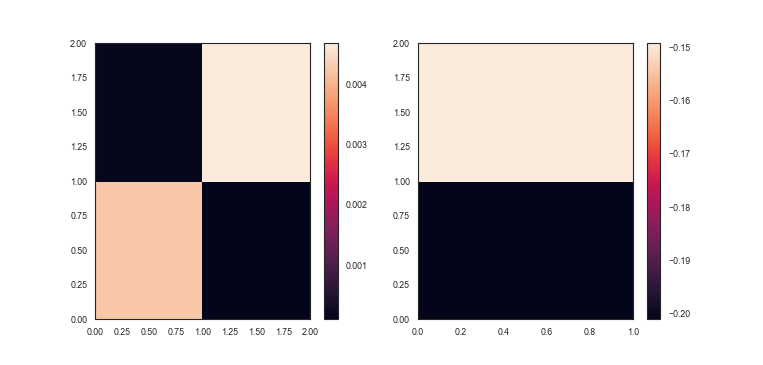

In [84]:
f, ax = plt.subplots(ncols = 2)
mat = np.squeeze(np.array(np.dot(kg, np.dot(C, A))))
c = ax[0].pcolormesh(mat[np.ix_([0, 1], [3, 5])])
c1 = ax[1].pcolormesh(mat[np.ix_([0, 1], [6])])
f.colorbar(c, ax=ax[0])
f.colorbar(c1, ax=ax[1])

In [93]:
########### Get out all the KexpCAx values ########
def get_kexpcax(A, C, kg, ck, est_np):
    trl = len(ck)
    
    kexpcax = []
    for i_t in range(trl):
        
        ##### Estimate ######
        CAx = np.dot(C, np.dot(A, ck[i_t].T))
        Kexp_CAx = np.squeeze(np.array(-1*np.dot(kg, np.exp(CAx))))
        kexpcax.append(Kexp_CAx)
    
    return kexpcax

In [94]:
kexpcax = get_kexpcax(A, C, kg, ub_ck, ub_est_np)

<IPython.core.display.Javascript object>


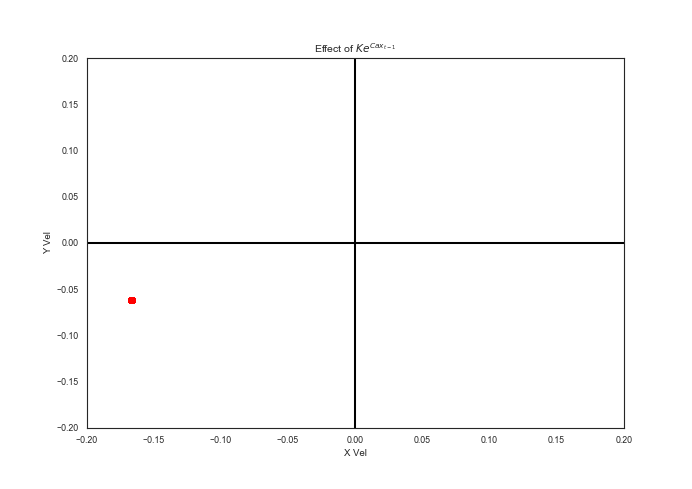

Text(0.5,1,'Effect of $Ke^{Cax_{t-1}}$')

In [101]:
f, ax = plt.subplots()
for k in kexpcax:
    ### Currently in m/sec
    k = 100*k
    ax.plot(k[0, :], k[1, :], 'r.')
ax.vlines(0, -.2, .2, 'k')
ax.hlines(0, -.2, .2, 'k')
ax.set_xlim([-.2, .2])
ax.set_ylim([-.2, .2])
ax.set_xlabel('X Vel')
ax.set_ylabel('Y Vel')
ax.set_title('Effect of $Ke^{Cax_{t-1}}$')